In [1]:
import os
import sys
import PyQt5
import numpy as np
import cv2
from mayavi import mlab
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.ndimage import median_filter
import tifffile

In [2]:
# Define Metadata for the data file 
# You should be able to get this info in ImageJ from Image > Properties
X_SCALE = 3791586e-7       # pixel width
Y_SCALE = 3791586e-7       # pixel height
Z_SCALE = 10045202e-7       # voxel depth

# Additional parameters: 
Z_REF = 0 
VALUE_THRESHOLD = 0.10     # to remove background (needs fine-tuning per cell)

In [3]:
def open_tif(file_path):
    """
    Given a tif file path, it stores the z-stack in the array 'image' and 
    reads its dimensions.  
    """
  
    image        = tifffile.imread(file_path)
    num_slices   = image.shape[0]  
    num_channels = image.shape[1]  
    x_dim        = image.shape[2]  
    y_dim        = image.shape[3]  
    
   
    data_shape = [num_slices, num_channels, x_dim, y_dim]
    
    return image, data_shape

def preprocess_image(slice, channel_mult, VALUE_THRESHOLD):
    """
    Each image has 3 channels and at each channel we have images of different protein structures of the cells.
    What we would like to do is to normalize each channel first then threshold in HSV space to determine where we 
    denote the strctural elements for didinium locations. 

    Inputs : 
        slice_input : current slice we are considering, an image
        channel_mult : an array with 3 values. 
        example use if channel_mult = [1, 1, 1] each channel is multiplied with 1.0 before thresholding operations
                    if channel_mult = [0, 0, 1] you are only taking the structure in the last channel 
                    if channel_mult = [0, 0, 5] maybe you are not getting enough data points to represent the channel
                    structure so you'd want to multiply the channel with a higher value so that more datapoints are above
                    the threshold for 3D representation of the channel. 
        VALUE_THRESHOLD : threshold for putting a point in location, should be between 0 and 1
                          if VALUE_THRESHOLD is high you'll have a more dense point cloud and vice versa
    """

    assert len(channel_mult) == 3, "channel_mult should be an array with 3 inputs."
    assert 0.0 < VALUE_THRESHOLD and VALUE_THRESHOLD < 1.0, "VALUE_THRESHOLD should be between 0 and 1"
    
    
    # Find the minimum and maximum values in the array
    min_value = slice.min()
    max_value = slice.max()
    
    # Normalize the array to the range [0, 1]
    slice = (slice - min_value) / (max_value - min_value)
    
    # Convert the 3D array to an image
    image = np.moveaxis(slice, 0, -1)

    # Multiply channel values to eliminate some channels if preferred
    image[ :, :, 0] = image[ :, :, 0] * channel_mult[0]
    image[ :, :, 1] = image[ :, :, 1] * channel_mult[1]
    image[ :, :, 2] = image[ :, :, 2] * channel_mult[2]
    
    # Convert RGB to HSV and extract the value (V) channel
    hsv_image = colors.rgb_to_hsv(image)
    
    value_channel = hsv_image[:,:, 2]
    
    value_channel_thresh = np.copy(value_channel)
    
    # This thresholding needs some fine tuning 
    value_channel_thresh[value_channel < VALUE_THRESHOLD] = 0.0
    value_channel_thresh[value_channel_thresh > 0.0] = 1.0
    
    return value_channel_thresh


def generate_point_cloud(channels, shape, X_SCALE, Y_SCALE, Z_SCALE, 
                         channel_mult=[1, 1, 1], n = 3, VALUE_THRESHOLD=0.33) -> np.ndarray:
    """
    Generate point cloud from zstack 

    Inputs : 
        channels : zstack of all channels in RGB
        shape : computed from zstack
        X_SCALE, Y_SCALE, Z_SCALE : metadata
        channel_mult : an array with 3 values. 
        example use if channel_mult = [1, 1, 1] each channel is multiplied with 1.0 before thresholding operations
                    if channel_mult = [0, 0, 1] you are only taking the structure in the last channel 
                    if channel_mult = [0, 0, 5] maybe you are not getting enough data points to represent the channel
                    structure so you'd want to multiply the channel with a higher value so that more datapoints are above
                    the threshold for 3D representation of the channel. 
        VALUE_THRESHOLD : threshold for putting a point in location, should be between 0 and 1
                          if VALUE_THRESHOLD is high you'll have a more dense point cloud and vice versa
    Returns:
        array of point cloud locations xyz as numpy array
    """
    point_cloud = []
    for z in range(shape[0]-n):
        curr_img = channels[z,:,:,:]
        processed_img = preprocess_image(curr_img, channel_mult=channel_mult, VALUE_THRESHOLD=VALUE_THRESHOLD)
       
        for i in range(processed_img.shape[0]):
            for j in range(processed_img.shape[1]):
                if processed_img[i,j] != 0.0:
                    loc = pixel_to_xyz(X=i, Y=j, Z=z, X_SCALE=X_SCALE, Y_SCALE=Y_SCALE, Z_SCALE=Z_SCALE)
                    point_cloud.append(loc)

    print("Point Cloud is Generated!")

    return np.transpose(point_cloud) # transpose works the best



def pixel_to_xyz(X, Y, Z, X_SCALE, Y_SCALE, Z_SCALE):
    """
    Calculate xyz location based on image scale and location on image
    X_SCALE, Y_SCALE, Z_SCALE : metadata
    """
    return np.array([X*X_SCALE, Y*Y_SCALE, Z*Z_SCALE])


def visualize_pointcloud(data, title = None, fig_id = 1):
    # For visualizing point clouds
    x = data[0,:] 
    y = data[1,:] 
    z = data[2,:] 

    if title is None:
        title = "Point Cloud"

    # Visualize it with mlab.surf
    col = z
    fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(128*5,128*5))
    mlab.points3d(x, 
                  y, 
                  z,
                  col,
                  mode="point",
                  colormap='spectral',
                  figure=fig,
                  )
    mlab.title(title, height=0.1, size=0.4)

In [4]:
raw_data_file = "C:\\Users\\Sama Wael\\OneDrive\\Desktop\\Epfl\\LPL Internship\\Summer projects 2024\\Didinium\\20240705-dapi_asc_tub_poly_e_20_june_sample.lif - Image 2.tif"

In [5]:
channels_input, channels_input_shape = open_tif(raw_data_file)

# The image I shared has two channels corresponding to staining of different proteins. However, the code always 
# expects 3 channels!  To avoid errors from the function preprocess_image I am creating a fake empty channel with zeros 
# that will be thresholded and removed anyway by selecting channel_mult = [#, #, 0] in the generate_point_cloud function. 

# Create a fake channel to match expected dimensions
fake_channel = np.zeros_like(channels_input[:,0:1,:,:])

# Concatenate to the real input 
channels = np.concatenate((channels_input, fake_channel), axis=1)
channels_shape = channels.shape

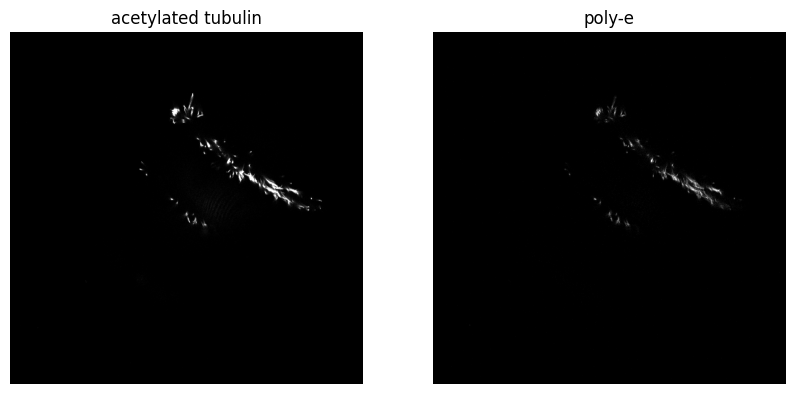

In [6]:
# Visualization of a given slice
slice_number = 10

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('acetylated tubulin')
plt.imshow(channels[slice_number,0,:,:], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('poly-e')
plt.imshow(channels[slice_number,1,:,:], cmap='gray')
plt.axis('off')
plt.show()


In [7]:
# now construct the whole structure
point_cloud_test_both = generate_point_cloud(channels, channels_shape, X_SCALE, Y_SCALE, Z_SCALE, channel_mult=[5, 5, 0], n = 3, VALUE_THRESHOLD=0.33)                                     

# just the first channel 
point_cloud_test_1 = generate_point_cloud(channels, channels_shape, X_SCALE, Y_SCALE, Z_SCALE, channel_mult=[5, 0, 0], n = 3, VALUE_THRESHOLD=0.33)                                     

# just the second channel 
point_cloud_test_2 = generate_point_cloud(channels, channels_shape, X_SCALE, Y_SCALE, Z_SCALE, channel_mult=[0, 5, 0], n = 3, VALUE_THRESHOLD=0.33)                                     
                                       

Point Cloud is Generated!
Point Cloud is Generated!
Point Cloud is Generated!


In [8]:
%gui qt
# visualize the whole structure
visualize_pointcloud(data=point_cloud_test_both, fig_id=1)
# visualize the first channel 
visualize_pointcloud(data=point_cloud_test_1, fig_id=2)
# visualize the second channel 
visualize_pointcloud(data=point_cloud_test_2, fig_id=3)

In [9]:
def compute_max_spread_point(point_cloud):
    # Compute the mean point
    mean_point = np.mean(point_cloud, axis=1)
    # Compute the distances from the mean
    diffs = point_cloud - mean_point[:, np.newaxis]
    dists = np.linalg.norm(diffs, axis=0)
    # Find the index of the maximum distance
    max_spread_index = np.argmax(dists)
    return point_cloud[:, max_spread_index]

def project_point_onto_plane(point, normal, point_on_plane):
    point_to_plane = point - point_on_plane
    distance = np.dot(point_to_plane, normal)
    projected_point = point - distance * normal
    return projected_point

def project_points_onto_plane(point_cloud, normal, point_on_plane):
    # Project each point onto the plane
    projected_points = np.apply_along_axis(project_point_onto_plane, 1, point_cloud.T, normal, point_on_plane)
    return projected_points.T  # Transpose back to (3, N)

def visualize_pointcloud_with_axis_and_plane(point_cloud, axis, mean, plane_point, title=None, fig_id=1):
    x = point_cloud[0, :] 
    y = point_cloud[1, :] 
    z = point_cloud[2, :] 

    if title is None:
        title = "Point Cloud with Axis of Symmetry and Plane"

    col = z
    fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(800, 800))
    mlab.points3d(x, y, z, col, mode="point", colormap='spectral', figure=fig)
    
    # Plot the axis of symmetry
    mlab.plot3d([mean[0] - 50 * axis[0], mean[0] + 50 * axis[0]],
                [mean[1] - 50 * axis[1], mean[1] + 50 * axis[1]],
                [mean[2] - 50 * axis[2], mean[2] + 50 * axis[2]],
                tube_radius=1, color=(1, 1, 1))
    
    # Plot the balanced plane
    normal = np.cross(axis, plane_point - mean)
    normal /= np.linalg.norm(normal)
    d = -np.dot(normal, mean)
    xx, yy = np.meshgrid(np.linspace(mean[0] - 50, mean[0] + 50, 10), 
                         np.linspace(mean[1] - 50, mean[1] + 50, 10))
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
    
    mlab.mesh(xx, yy, zz, opacity=0.5, color=(0, 1, 0))
    
    mlab.title(title, height=0.1, size=0.4)
    mlab.show()

def visualize_projected_points(projected_points, title=None, fig_id=2):
    x = projected_points[0, :] 
    y = projected_points[1, :] 
    z = projected_points[2, :] 

    if title is None:
        title = "Projected Points on the Plane"

    col = z
    fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(800, 800))
    mlab.points3d(x, y, z, col, mode="point", colormap='spectral', figure=fig)
    
    mlab.title(title, height=0.1, size=0.4)
    mlab.show()

def find_balanced_plane(point_cloud, axis, mean_point):
    def compute_plane_params(normal, point):
        d = -np.dot(normal, point)
        distances = np.dot(point_cloud.T, normal) + d
        return np.abs(distances)

    initial_plane_point = compute_max_spread_point(point_cloud)
    initial_plane_normal = np.cross(axis, initial_plane_point - mean_point)
    initial_plane_normal /= np.linalg.norm(initial_plane_normal)
    
    best_plane_point = mean_point
    min_deviation = np.inf
    for i in range(10):
        offset = (np.random.rand(3) - 0.5) * 10
        trial_plane_point = mean_point + offset
        normal = np.cross(axis, trial_plane_point - mean_point)
        normal /= np.linalg.norm(normal)
        distances = compute_plane_params(normal, trial_plane_point)
        deviation = np.std(distances)
        if deviation < min_deviation:
            min_deviation = deviation
            best_plane_point = trial_plane_point

    best_plane_normal = np.cross(axis, best_plane_point - mean_point)
    best_plane_normal /= np.linalg.norm(best_plane_normal)

    return best_plane_point, best_plane_normal

# Performing PCA
pca = PCA(n_components=3)
pca.fit(point_cloud_test_1.T)
refined_axis_of_symmetry = pca.components_[0]
mean_point = np.mean(point_cloud_test_1, axis=1)

# Balancing of Generated Plane and Visualization
balanced_plane_point, balanced_plane_normal = find_balanced_plane(point_cloud_test_1, refined_axis_of_symmetry, mean_point)
projected_points_2 = project_points_onto_plane(point_cloud_test_2, balanced_plane_normal, balanced_plane_point)
# visualize_pointcloud_with_axis_and_plane(point_cloud_test_1, refined_axis_of_symmetry, mean_point, balanced_plane_point)

# Visualization of the projected points separately
visualize_projected_points(projected_points_2)

In [16]:
######################### Adjust Brightness threshold and filter size to identify the points that you want to keep ###########################
def pointcloud_to_grayscale(x, y, z=None, image_size=(512, 512), brightness_threshold=15, filter_size=5):    
    # Create the grayscale image
    hist, xedges, yedges = np.histogram2d(x, y, bins=image_size, weights=z)
    hist /= np.max(hist)

    # Apply median filter to the histogram
    hist_filtered = median_filter(hist, size=filter_size)

    # Normalize the histogram to the range [0, 255]
    hist_normalized = (hist_filtered * 255).astype(np.uint8)

    # Identify bright pixels
    binary_image = hist_normalized >= brightness_threshold
    binary_image = binary_image.astype(np.uint8) * 255

    # Create a color image from the grayscale image
    color_image = cv2.cvtColor(hist_normalized, cv2.COLOR_GRAY2BGR)

    # Get the coordinates of bright pixels
    bright_pixels = np.argwhere(binary_image > 0)

    # Initialize cluster visualization
    cluster_image = np.zeros_like(hist_normalized)

    # Define scaling factors
    X_SCALE = 3554611e-7  # pixel width in meters
    Y_SCALE = 3554611e-7  # pixel height in meters

    # Use Gaussian Mixture Model to find clusters
    if len(bright_pixels) >= 2:
        gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(bright_pixels)
        labels = gmm.predict(bright_pixels)

        # Get centroids of the clusters
        centroid1 = gmm.means_[0]
        centroid2 = gmm.means_[1]

        # Visualize clusters
        cluster_image[bright_pixels[labels == 0][:, 0], bright_pixels[labels == 0][:, 1]] = 128  # Gray for cluster 1
        cluster_image[bright_pixels[labels == 1][:, 0], bright_pixels[labels == 1][:, 1]] = 255  # White for cluster 2

        # Calculate the Euclidean distance between the two centroids in pixels
        pixel_distance = np.linalg.norm(centroid1 - centroid2)
        
        # Convert pixel distance to real-world units
        real_distance_x = pixel_distance * X_SCALE
        real_distance_y = pixel_distance * Y_SCALE
        real_distance = np.sqrt(real_distance_x**2 + real_distance_y**2)

        print(f"Pixel distance between the two centroids: {pixel_distance:.2f} pixels")
        print(f"Real-world distance between the two centroids: {real_distance:.2f} Micrometers")

        # Draw lines and annotate distance on the image
        centroid1 = tuple(map(int, centroid1))
        centroid2 = tuple(map(int, centroid2))
        cv2.circle(color_image, centroid1[::-1], 5, (255, 0, 0), -1)  # Red circle for centroid 1
        cv2.circle(color_image, centroid2[::-1], 5, (0, 0, 255), -1)  # Blue circle for centroid 2
        cv2.line(color_image, centroid1[::-1], centroid2[::-1], (0, 255, 0), 1)  # Green line between centroids
        
        # Annotate the distance on the image
        mid_point = tuple(np.round((np.array(centroid1) + np.array(centroid2)) / 2).astype(int))
        # cv2.putText(color_image, f"{real_distance:} m", mid_point, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

    # Plot the grayscale image, the filtered grayscale image, the binary image, the cluster image, and the final color image with lines
    fig, axs = plt.subplots(1, 5, figsize=(40, 8))
    axs[0].imshow(hist_normalized.T, origin='lower', cmap='gray')
    axs[0].set_title('Original Grayscale Image from Point Cloud')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')

    axs[1].imshow(hist_filtered.T, origin='lower', cmap='gray')
    axs[1].set_title('Filtered Grayscale Image')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')

    axs[2].imshow(binary_image.T, origin='lower', cmap='gray')
    axs[2].set_title('Binary Image with Bright Pixels')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')

    axs[3].imshow(cluster_image.T, origin='lower', cmap='gray')
    axs[3].set_title('GMM Clusters Visualization')
    axs[3].set_xlabel('X')
    axs[3].set_ylabel('Y')

    axs[4].imshow(color_image, origin='lower')
    axs[4].set_title('Image with Centroids and Distance Line')
    axs[4].set_xlabel('X')
    axs[4].set_ylabel('Y')

    plt.show()

    return hist, xedges, yedges, color_image

Pixel distance between the two centroids: 199.05 pixels
Real-world distance between the two centroids: 100.06 Micrometers


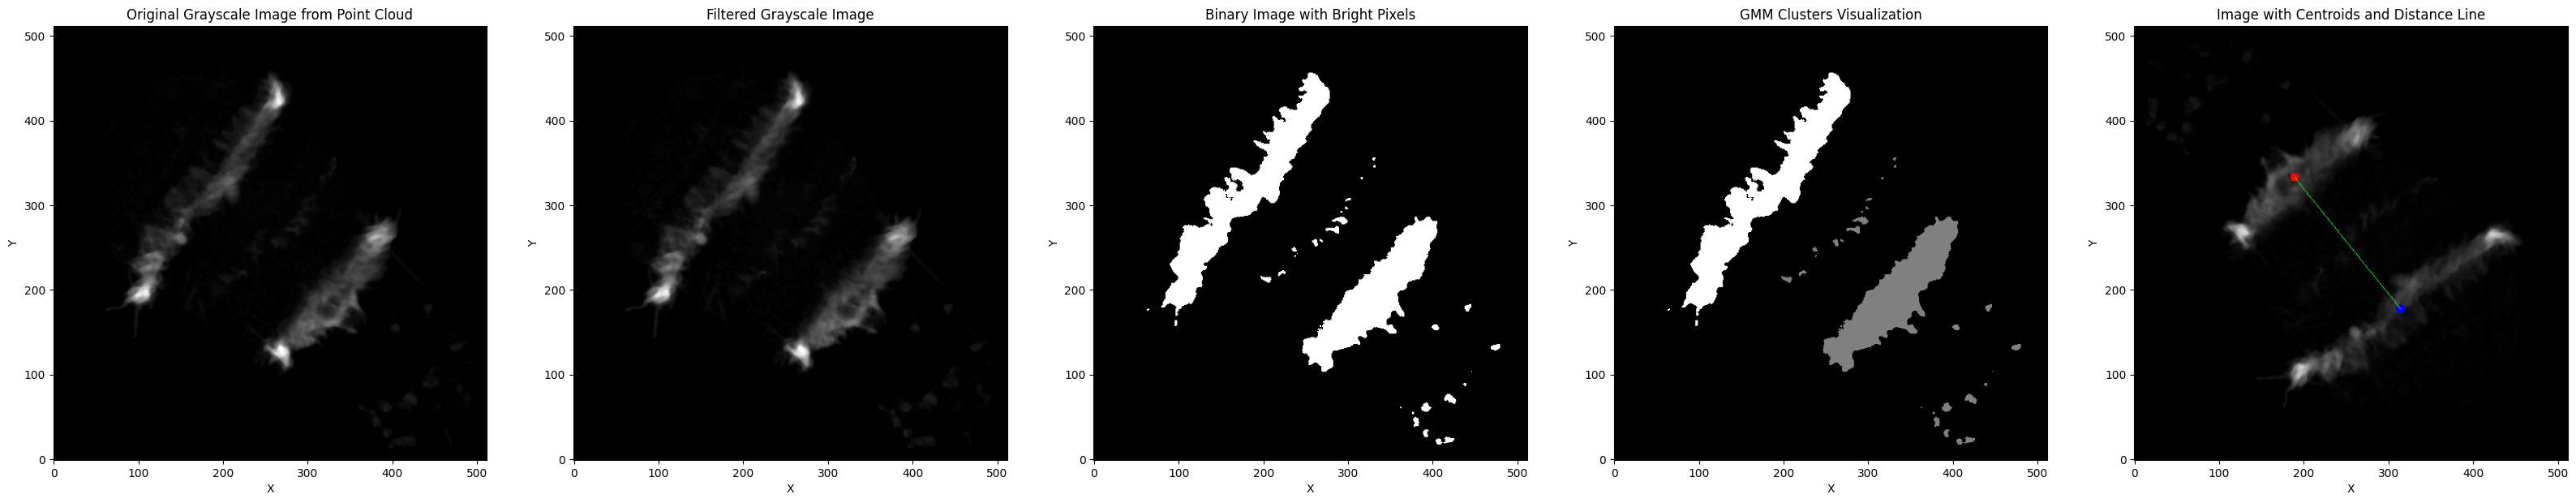

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-7.51495285e+00, -7.10654626e+00, -6.69813966e+00, -6.28973307e+00,
        -5.88132647e+00, -5.47291988e+00, -5.06451328e+00, -4.65610669e+00,
        -4.24770010e+00, -3.83929350e+00, -3.43088691e+00, -3.02248031e+00,
        -2.61407372e+00, -2.20566712e+00, -1.79726053e+00, -1.38885393e+00,
        -9.80447338e-01, -5.72040744e-01, -1.63634149e-01,  2.44772446e-01,
         6.53179040e-01,  1.06158563e+00,  1.46999223e+00,  1.87839882e+00,
         2.28680542e+00,  2.69521201e+00,  3.10361861e+00,  3.51202520e+00,
         3.92043180e+00,  4.32883839e+00,  4.73724499e+00,  5.14565158e+00,
         5.55405818e+00,  5.96246477e+00,  6.37087137e+00,  6.77927796e+00,
         7.18768455e+00,  7.59609115e+00,  8.00449774e+00,  8.41290

In [17]:
pointcloud_to_grayscale(projected_points_2[0, :], projected_points_2[1, :], projected_points_2[2, :])